Looking for a EEG stream...
Can't find EEG stream.
Recording has ended


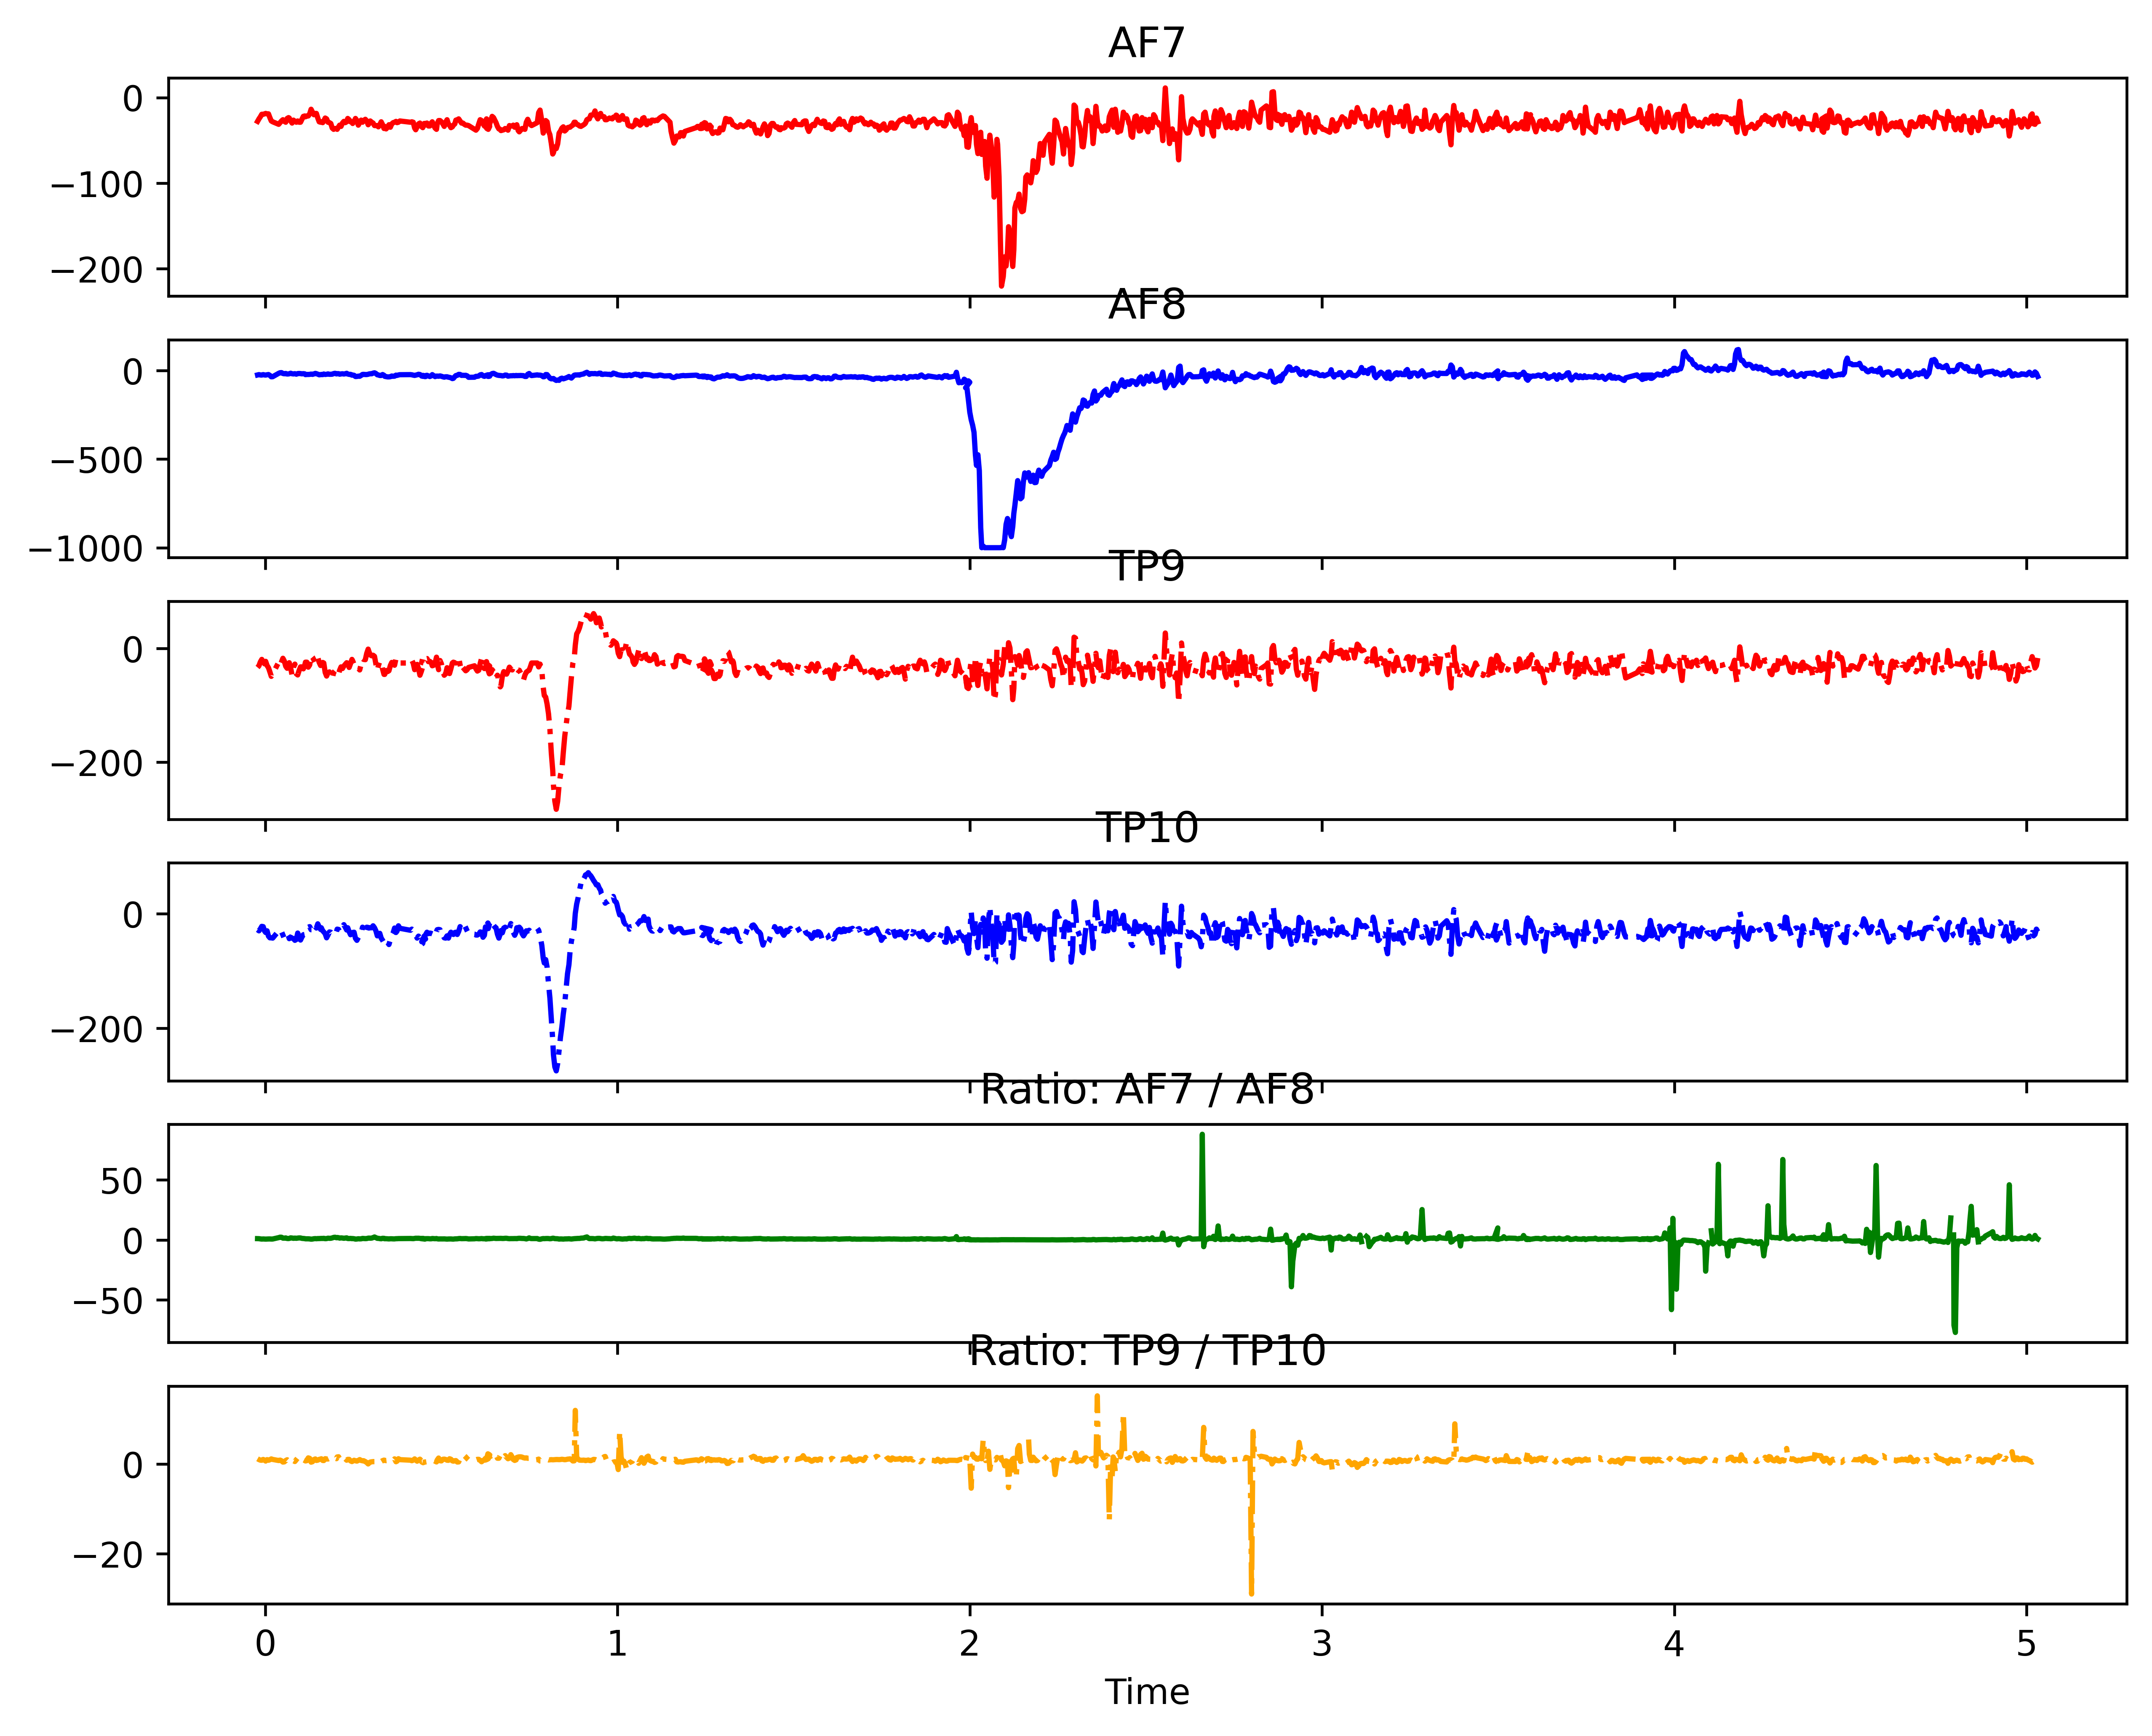

In [63]:
# Record and format Muse 2 data

from muselsl import record
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

file = "right_blink_var1_10"
folder = "../Collected_Data/"
input_file = folder+"RawEEG/right_blink/" + file + "_raw.csv"
output_file = folder+"FormattedEEG/right_blink/" + file + "_formatted.csv"

# Note: an existing Muse LSL stream is required
record(10, input_file)
# Note: Recording is synchronous, so code here will not execute until the stream has been closed
print('Recording has ended')

# Read, format, and save recorded data
plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['figure.dpi'] = 600 # 200 e.g. is really fine, but slower
df = pd.read_csv(input_file, usecols=[1,2,3,4,5,6], header=0, names=["TP9", "AF7", "AF8","TP10", "Time", "Offset"])
df["Time"] = df["Time"] + df["Offset"] - df["Time"].iloc[0]
del df["Offset"]
df.to_csv(output_file)

# Plot formatted data
fig,(graph0, graph1, graph2, graph3, graph4, graph5) = plt.subplots(nrows = 6, sharex = True)
line0, = graph0.plot(df["Time"], df["AF7"], color = "red", linestyle = "solid")
line1, = graph1.plot(df["Time"], df["AF8"], color = "blue", linestyle = "solid")
line2, =  graph2.plot(df["Time"], df["TP9"], color = "red", linestyle = "dashdot")
line3, = graph3.plot(df["Time"], df["TP10"], color = "blue", linestyle = "dashdot")
line4, = graph4.plot(df["Time"], (df["AF7"]/df["AF8"]), color = "green", linestyle = "solid")
line5, = graph5.plot(df["Time"], (df["TP9"]/df["TP10"]), color = "orange", linestyle = "dashdot")

graph0.title.set_text('AF7')
graph1.title.set_text('AF8')
graph2.title.set_text('TP9')
graph3.title.set_text('TP10')
graph4.title.set_text('Ratio: AF7 / AF8')
graph5.title.set_text('Ratio: TP9 / TP10')

#graph4.legend((line0, line1, line2, line3), ("AF7", "AF8", "TP9", "TP10"), loc='lower right')
plt.xlabel('Time')
plt.show()




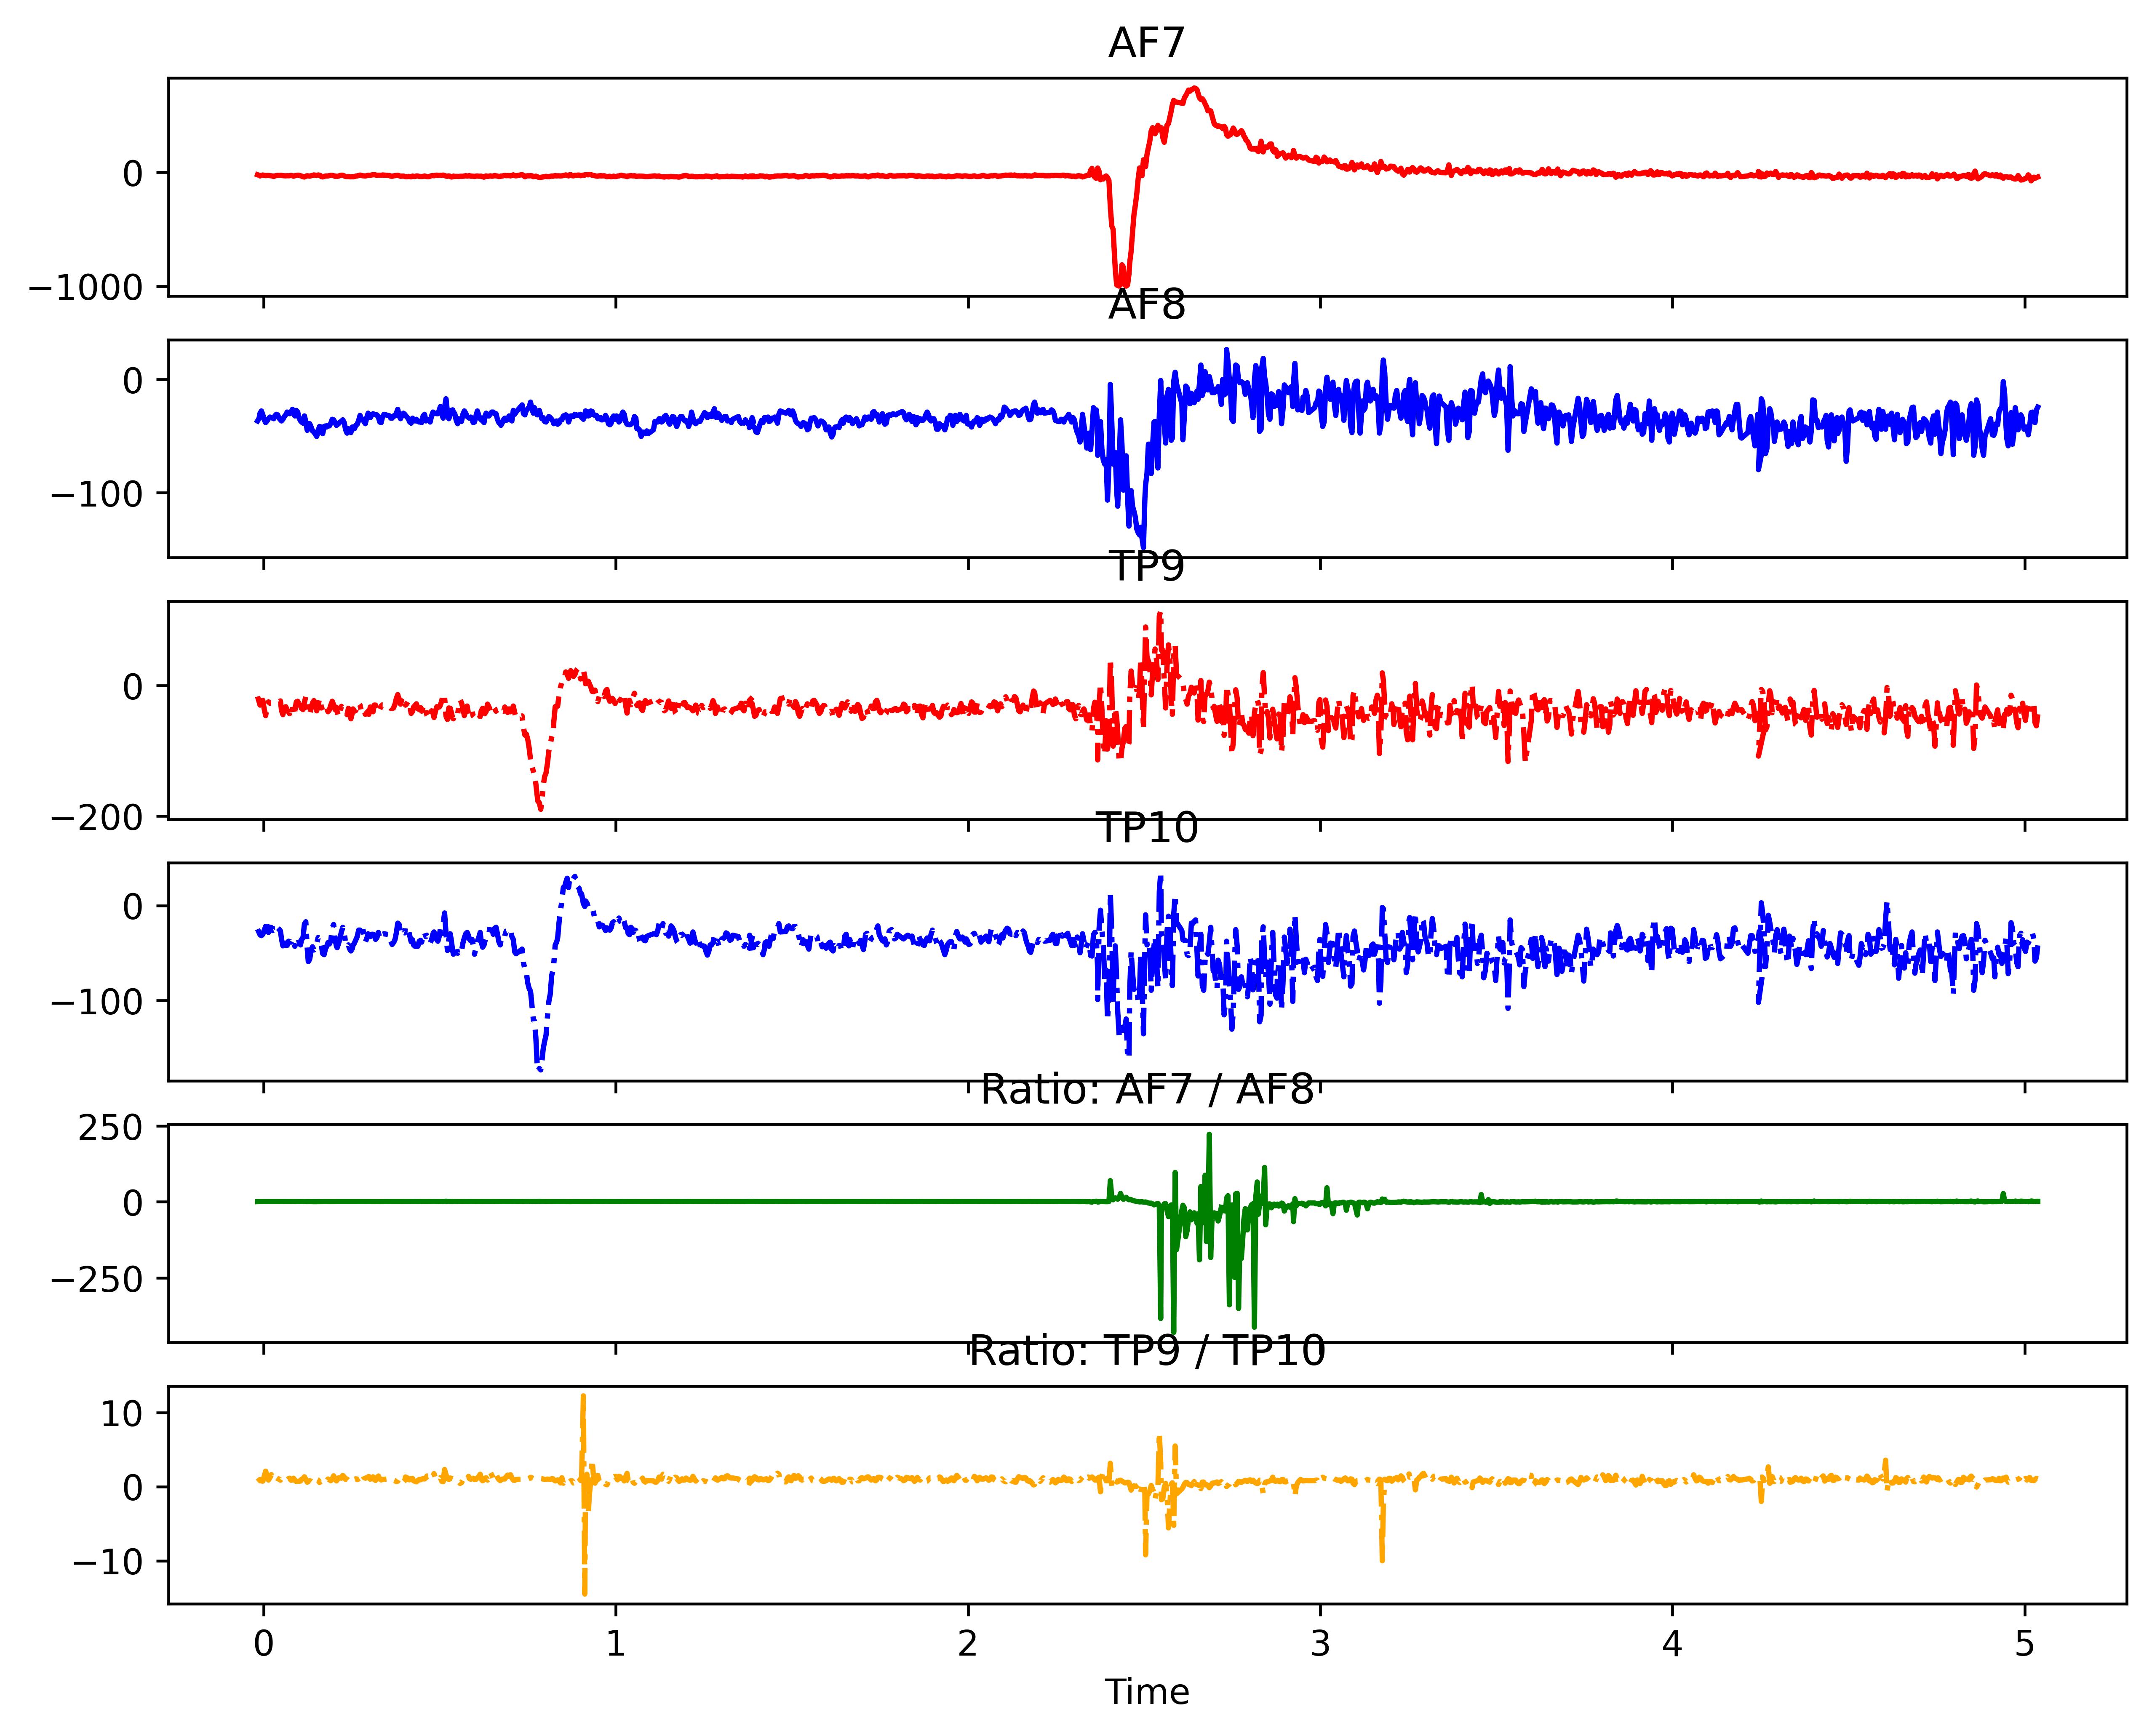

In [64]:
file = "left_blink_var1_1"
folder = "../Collected_Data/"
input_file = folder+"RawEEG/left_blink/" + file + "_raw.csv"

df = pd.read_csv(input_file, usecols=[1,2,3,4,5,6], header=0, names=["TP9", "AF7", "AF8","TP10", "Time", "Offset"])
df["Time"] = df["Time"] + df["Offset"] - df["Time"].iloc[0]
del df["Offset"]

# Plot formatted data
plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['figure.dpi'] = 600 # 200 e.g. is really fine, but slower
fig,(graph0, graph1, graph2, graph3, graph4, graph5) = plt.subplots(nrows = 6, sharex = True)
line0, = graph0.plot(df["Time"], df["AF7"], color = "red", linestyle = "solid")
line1, = graph1.plot(df["Time"], df["AF8"], color = "blue", linestyle = "solid")
line2, =  graph2.plot(df["Time"], df["TP9"], color = "red", linestyle = "dashdot")
line3, = graph3.plot(df["Time"], df["TP10"], color = "blue", linestyle = "dashdot")
line4, = graph4.plot(df["Time"], (df["AF7"]/df["AF8"]), color = "green", linestyle = "solid")
line5, = graph5.plot(df["Time"], (df["TP9"]/df["TP10"]), color = "orange", linestyle = "dashdot")

graph0.title.set_text('AF7')
graph1.title.set_text('AF8')
graph2.title.set_text('TP9')
graph3.title.set_text('TP10')
graph4.title.set_text('Ratio: AF7 / AF8')
graph5.title.set_text('Ratio: TP9 / TP10')

#graph4.legend((line0, line1, line2, line3), ("AF7", "AF8", "TP9", "TP10"), loc='lower right')
plt.xlabel('Time')
plt.show()